In [1]:
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as o
from scipy import signal
from lmfit.models import LinearModel, LorentzianModel

In [2]:
def clean(iterations, min_freq, data):
    #Local copy
    data = 1 * data

    #Remove residual baselines
    data -= np.nanmedian(data, axis=1) #I think this is right?
    
    #Padding size -- don't do anything if the data are already a 2^n size
    if (data.shape[1] & (data.shape[1] - 1)) == 0:
        highest_n = int(np.log10(data.shape[1]) / np.log10(2))
        
    else:
        highest_n = int(np.ceil(np.log10(data.shape[1]) / np.log10(2)) + 2)

    #Stores final model and residual arrays
    model_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
    resid_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
    
    #Stores *actual* FFT frequencies for model below
    fftfreqs  = np.fft.fftfreq(int(2**highest_n), d = np.abs(np.diff(f_sky)[0])) 
    
    for integ in range(data.shape[0]):
        
        #Data -- Pad integration time
        padded_integ = np.pad(data[integ, :], (0, 2**highest_n - data[integ, :].size))

        #Residual, i.e., = padded data - padded model, initialized to padded data since there's no model
        resid_init = 1 * np.fft.fft(padded_integ)
        resid = 1 * resid_init
        
        #Model -- Padded model 
        model = np.zeros(padded_integ.size, dtype='complex128')
        model_fft = np.zeros(resid.size, dtype='complex128')
        
        for step in range(iterations):
            
            #Find peak ABSOLUTE FFT amplitude
            resid_psd = np.abs(resid)
            peak_amp = np.nanmax(resid_psd[fftfreqs >= min_freq])
            
            #Find peak FFT frequency
            peak_base = np.flatnonzero(np.isclose(resid_psd, peak_amp))[0]
            
            #Model from FFT peak above
            model_fft[peak_base] += resid[peak_base].real + 1j * resid[peak_base].imag

            model = np.fft.ifft(model_fft, n = 2**highest_n)
            model[np.isclose(padded_integ, 0)] = 0

            resid = np.fft.fft(padded_integ - model.real)
            
        #TODO: Stopping criteria?
        
        #Store model
        model_fin[integ, :] = 1 * np.fft.ifft(model_fft, n=2**highest_n).real
   
    return model_fin, resid_fin

In [3]:
mir_data = MirParser("/home/jmichail/Desktop/OzoneData/211009_04:56:19", has_auto=True)

In [4]:
mir_data.unload_data()
mir_data.select(
    where=[
        ("sb", "eq", "u"),
        ("corrchunk","eq",4),
        ("ant", "eq",1),
        ("antrx","eq",0),
    ],
    reset=True
)
mir_data.load_data(load_auto=True, apply_tsys=False)

f_sky = (
    mir_data.ac_data['fsky'][0]
    + (np.arange(mir_data.ac_data['nch'][0]) - np.arange(mir_data.ac_data['nch'][0])/2)*mir_data.ac_data['fres'][0]*1e-3
)
f_sky = f_sky[1024:-1024]

In [5]:
sort_idx = np.argsort(mir_data.eng_data['actual_el'])

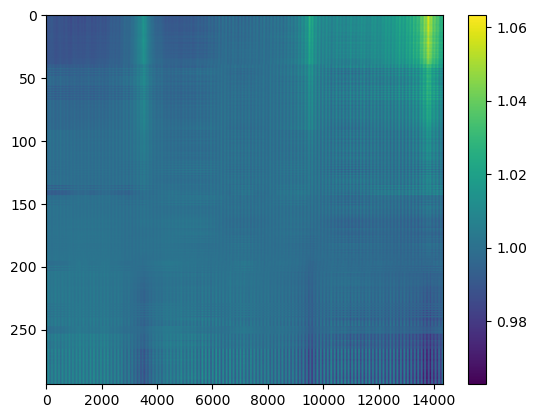

In [6]:
data_stack = np.vstack([item['data'] for item in mir_data.auto_data.values()])[:, 1024:-1024]
n_int, n_chan = data_stack.shape

data_stack = data_stack/np.repeat(np.median(data_stack,axis=0).reshape([1,-1]), n_int, axis=0)
data_stack = data_stack/np.repeat(np.median(data_stack,axis=1).reshape([-1,1]), n_chan, axis=1)

plt.imshow(data_stack[sort_idx, :], aspect='auto')
plt.colorbar()

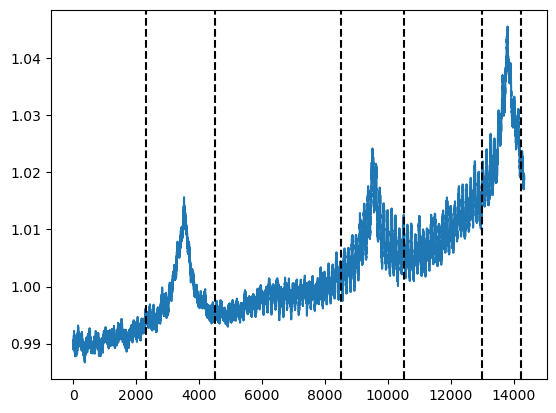

In [7]:
plt.plot(data_stack[50, :])
plt.axvline(2300, color='k', ls='--')
plt.axvline(4500, color='k', ls='--')
plt.axvline(8500, color='k', ls='--')
plt.axvline(10500, color='k', ls='--')
plt.axvline(13000, color='k', ls='--')
plt.axvline(data_stack[50, :].size-100, color='k', ls='--')

In [8]:
working_spec = 1 * data_stack
final_spec   = 1 * data_stack

ranges = [[2300, 4500], [8500, 10500], [13000, data_stack[50, :].size-5]]

baseline_indices = np.hstack([np.arange(0, 2300), np.arange(4500, 8500), np.arange(10500, 13000), np.arange(data_stack.shape[1]-100, data_stack.shape[1])])

for row in range(working_spec.shape[0]):
    p = np.polyfit(baseline_indices, data_stack[row, baseline_indices], 5)
    fit = np.poly1d(p)
    working_spec[row, baseline_indices] = data_stack[row, baseline_indices] - fit(baseline_indices)
    working_spec[row, baseline_indices] -= np.nanmean(working_spec[row, baseline_indices])

    final_spec[row, :] = data_stack[row, :] - fit(np.arange(data_stack.shape[1]))
    
    #Now mask lines regions
    for range_i in ranges:
        low, high = range_i[0], range_i[1]
        working_spec[row , low : high] = 0

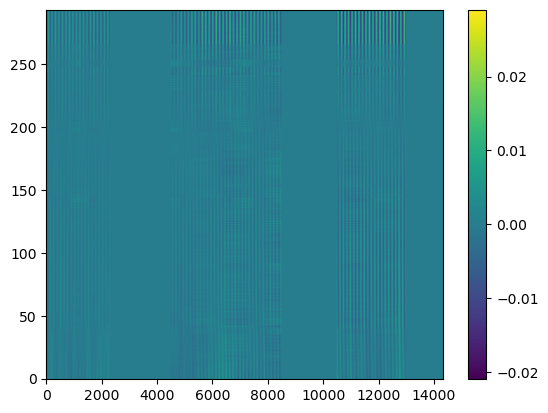

In [9]:
plt.imshow(working_spec[sort_idx, :], origin='lower', aspect='auto')
plt.colorbar()

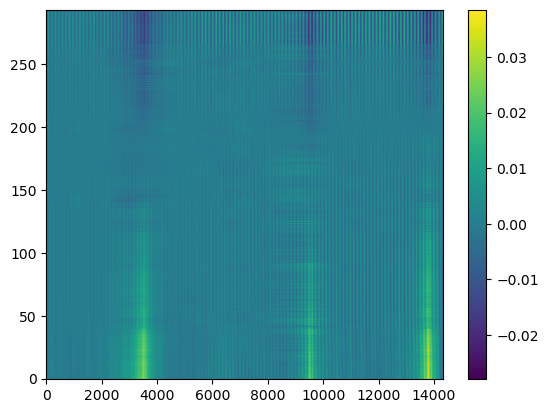

In [10]:
plt.imshow(final_spec[sort_idx, :], origin='lower', aspect='auto')
plt.colorbar()

In [11]:
mod, resid = clean(1000, 5, working_spec[50].reshape((1, working_spec[50].size)))

/home/jmichail/anaconda3/envs/pyuvdata/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jmichail/anaconda3/envs/pyuvdata/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(235.65, 235.85)

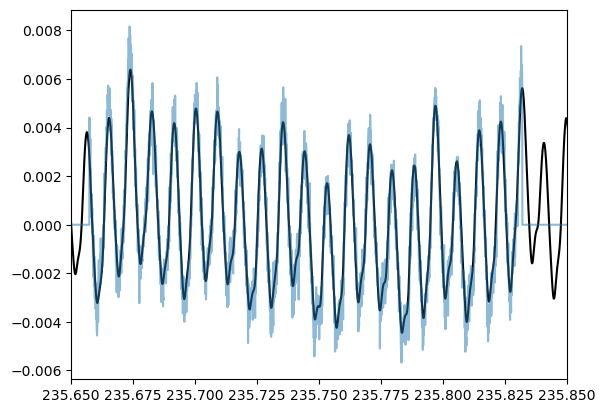

In [12]:
freqs_pad = f_sky[0] + np.diff(f_sky)[0] * np.arange(0, mod.size)
plt.plot(freqs_pad, mod[0, :], color='k')
plt.plot(f_sky, working_spec[50], alpha=0.5)
plt.xlim(235.65, 235.85)

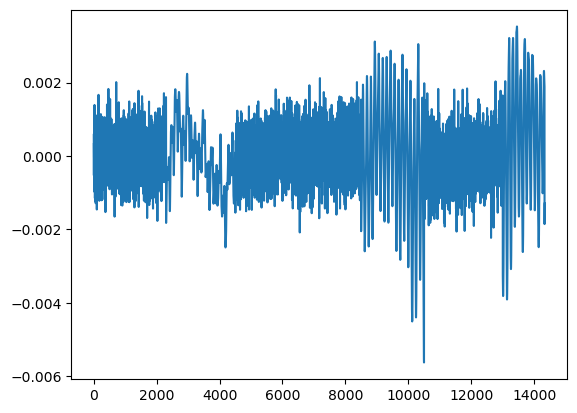

In [13]:
plt.plot(working_spec[50] - mod[0, :14336])

Text(0, 0.5, 'Normalized Autocorrelation')

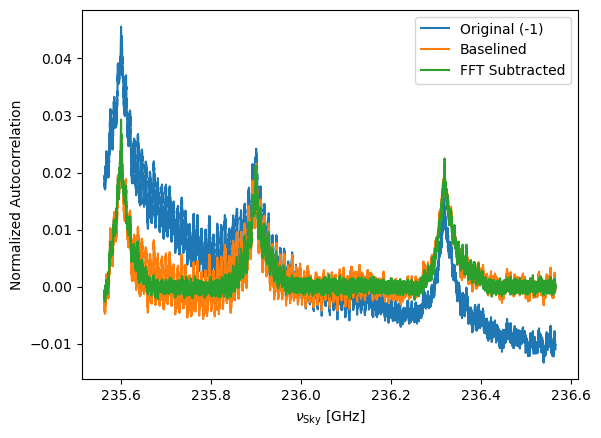

In [14]:
plt.plot(f_sky, data_stack[50, :]-1, label = "Original (-1)")
plt.plot(f_sky, final_spec[50, :], label = "Baselined")
plt.plot(f_sky, final_spec[50, :] - mod[0, :14336], label="FFT Subtracted")
plt.legend()
plt.xlabel("$\\nu_{\\rm{Sky}}$ [GHz]")
plt.ylabel("Normalized Autocorrelation")